In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import requests
import io
import xarray as xr
import calendar
from shapely.geometry import shape
import geopandas as gpd
from pystac_client import Client as StacClient
from dask.distributed import Client, LocalCluster
import stackstac
import warnings
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:

cluster = LocalCluster(
    n_workers=4,             
    threads_per_worker=1,    
    memory_limit="6GB"       
)
client = Client(cluster)
cluster    


LocalCluster(df9cc99f, 'tcp://127.0.0.1:37387', workers=4, threads=4, memory=22.35 GiB)

In [3]:
# Add the folder containing WQI_utils.py
sys.path.append(os.path.abspath("../utils"))

## 2 Import the main functions
# Import functions from your utils
from WQI_utils import compute_wqi_indices
from analysis_utils import plot_wqi_time_series, plot_wqi_seasonal

In [4]:
os.makedirs("outputs", exist_ok=True)

In [11]:
TBEP_BBOX = (-82.8, 27.5, -82.2, 28.1)
TBEP_TRIAL_BBOX = (-82.55, 27.75, -82.45, 27.85)

start_date = "2019-12-01"
end_date = "2024-12-31"

df_results, df_rolling, monthly_avg = compute_wqi_indices(
    bbox=TBEP_TRIAL_BBOX,
    start_date=start_date,
    end_date=end_date,
    max_items=50,      # later: 20, 40
    filter_clouds=True
)

print("Results shape:", df_results.shape if df_results is not None else "No data")
print(df_results.head())

/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Results shape: (50, 7)
                                  ndwi_mean  ndwi_median  ndti_mean  \
date                                                                  
2024-04-27 16:15:46.090000+00:00   0.178257     0.173943  -0.111185   
2024-05-02 16:15:49.847000+00:00   0.310724     0.347639  -0.235791   
2024-05-07 16:15:47.787000+00:00   0.178286     0.232628  -0.156603   
2024-05-12 16:15:50.159000+00:00   0.094230     0.177885  -0.110658   
2024-05-17 16:15:45.102000+00:00   0.184938     0.198589  -0.097663   

                                  ndti_median  ndci_mean  ndci_median  month  
date                                                                          
2024-04-27 16:15:46.090000+00:00    -0.109228   0.003209     0.001287      4  
2024-05-02 16:15:49.847000+00:00    -0.237133   0.025073     0.000000      5  
2024-05-07 16:15:47.787000+00:00    -0.160284   0.043467     0.011173      5  
2024-05-12 16:15:50.159000+00:00    -0.126437   0.057869     0.028807      5  
2024-

In [12]:
df_results.to_csv("outputs/tampa_tbep_trial50.csv", index=True)


In [13]:
df_full, df_roll_full, monthly_full = compute_wqi_indices(
    bbox=TBEP_BBOX,
    start_date=start_date,
    end_date=end_date,
    max_items=40,           # or whatever value you decided from Step 1
    filter_clouds=True
)
print("Full TBEP results shape:", df_full.shape)
print(df_results.head()

/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Full TBEP results shape: (40, 7)


In [22]:
df_full.shape
df_full.head()
df_full.index.is_monotonic_increasing

True

In [17]:
df_full = pd.read_csv(
    "outputs/tampa_tbep_full_40.csv",
    index_col="date",
    parse_dates=True
)

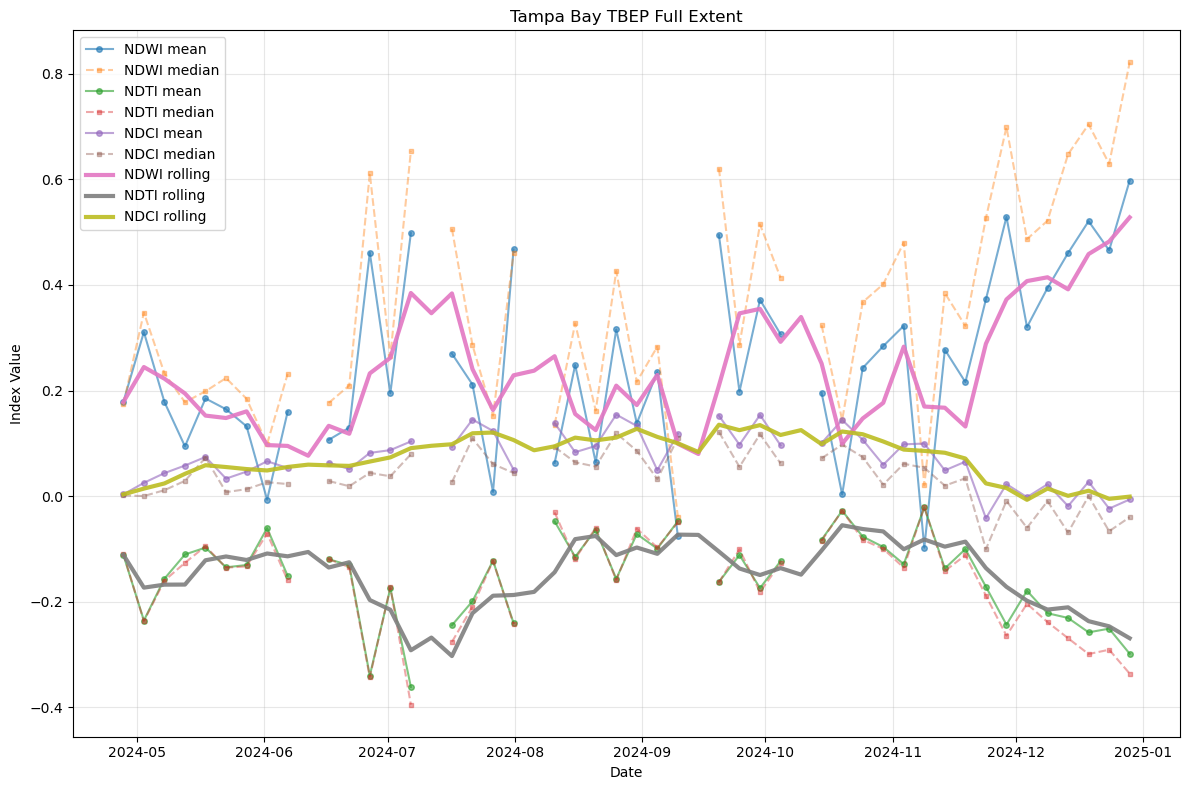

In [23]:
df_roll_full = df_full.rolling(window=3, min_periods=1).mean()
df_roll_full.head()          # should print quickly
plot_wqi_time_series(df_full, df_roll_full,
                     indices=["ndwi", "ndti", "ndci"],
                     title="Tampa Bay TBEP Full Extent")

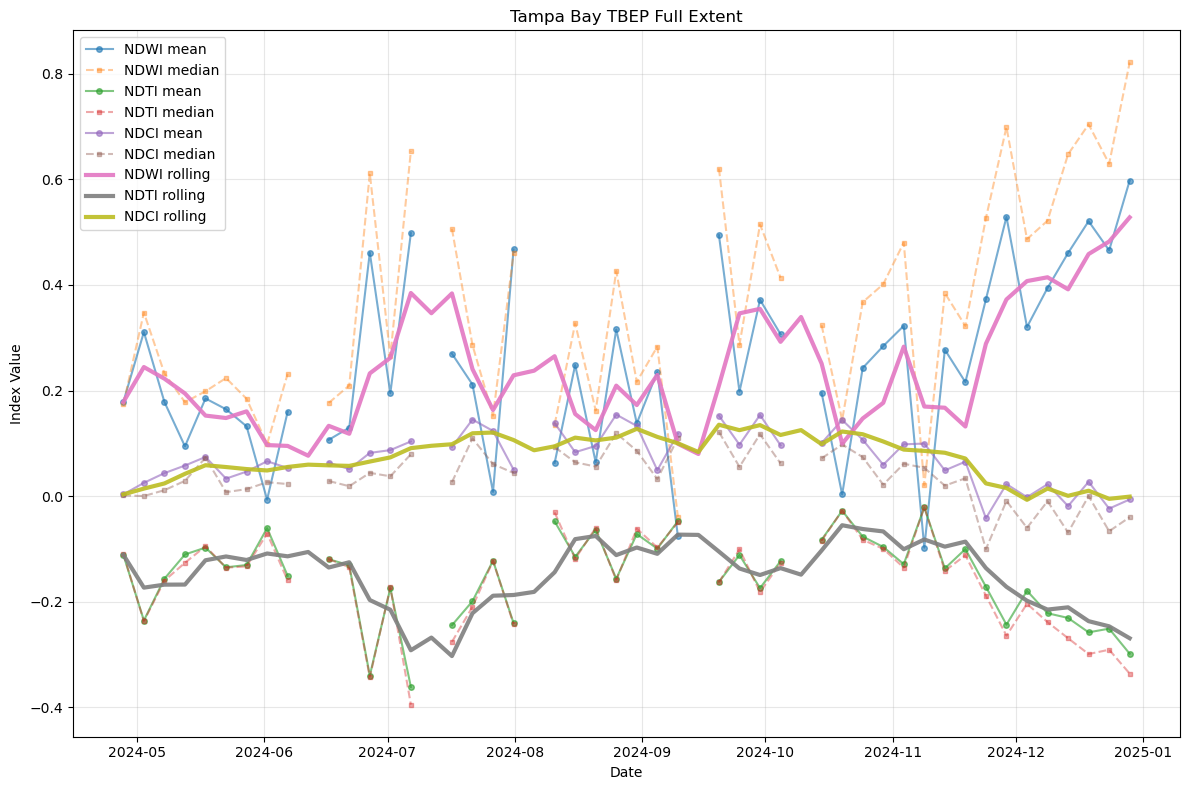

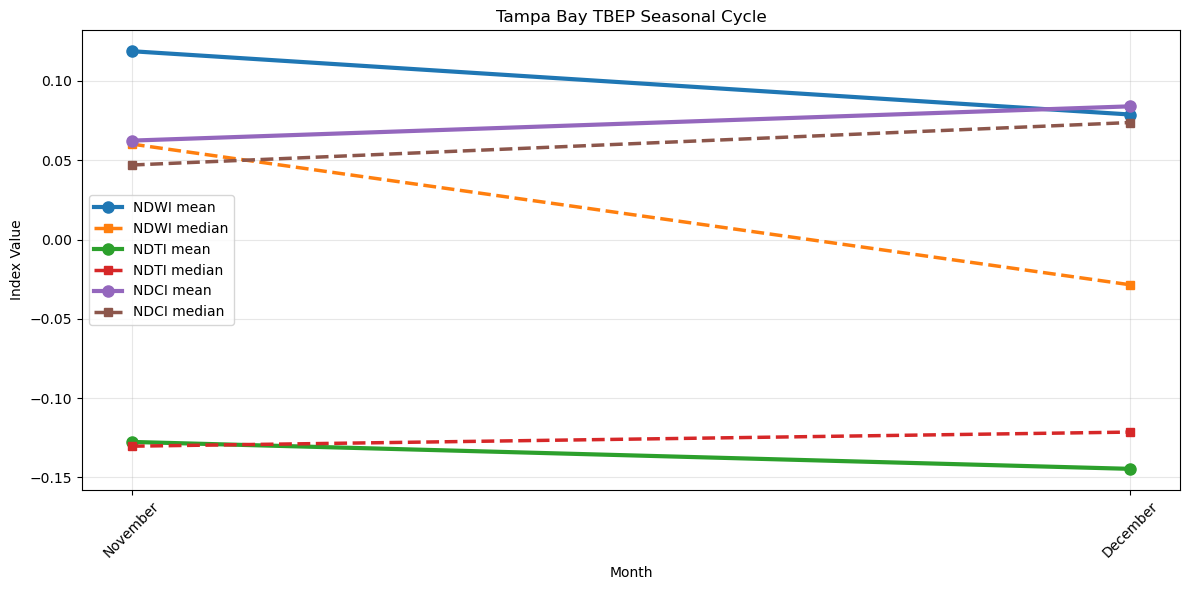

In [24]:
plot_wqi_time_series(
    df_full,
    df_rolling=df_roll_full,
    indices=["ndwi", "ndti", "ndci"],
    title="Tampa Bay TBEP Full Extent"
)

plot_wqi_seasonal(
    monthly_full,          # if you saved/recomputed this; otherwise recompute from df_full
    indices=["ndwi", "ndti", "ndci"],
    title="Tampa Bay TBEP Seasonal Cycle"
)